<a href="https://colab.research.google.com/github/jonesLevin/Machine-Learning/blob/main/Playground_Series_3_Episode_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemstone Price Prediction

In [42]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.9 MB/s eta 0:00:00


In [3]:
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c playground-series-s3e8

  0% 0.00/5.07M [00:00<?, ?B/s]
100% 5.07M/5.07M [00:00<00:00, 60.1MB/s]


In [5]:
!unzip playground-series-s3e8.zip

Archive:  playground-series-s3e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [45]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

plt.style.use('fivethirtyeight')
sns.set(style='darkgrid')

## Reading In The Data

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [8]:
train_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


## Feature Definitions:
Feature definitions from data dictionary:
- Carat: Carat weight of the cubic zirconia
- Cut: Describes the cut quality of the cubic zirconia. In order from best to worst:
 
 1. Ideal
 2. Premium
 3. Very Good
 4. Good
 5. Fair
- Color: Color of the cubic zirconia. With D being the best and J the worst.
- Clarity: Refers to the absence of the inclusions and blemishes. 
- Depth: The height of the cubic zirconia, measured from the culet to the table, divided by its average girdle diameter.
- Table: The width of the cubic zirconia's table expressed as a percentage of its average diameter.
- Price: The price of the zirconia
- x: The length in mm of the zirconia
- y: The whidth in mm of the zirconia
- z: The height in mm of the zirconia 

## Distribution of Features 

In [9]:
num_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
cat_features = ['cut', 'color', 'clarity']

### Distribution of CATEGORICAL Features

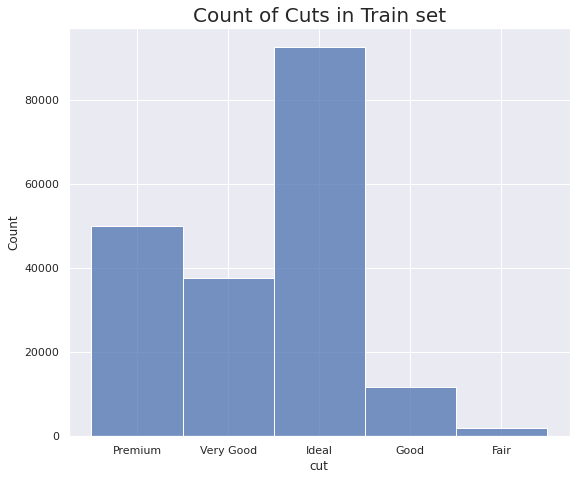

In [17]:
# Examining the 'cut' of the cubic zirconia
plt.figure(figsize=(8, 7))
ax = sns.histplot(data=train_df, x='cut')
ax.set_title('Count of Cuts in Train set', fontsize=20)
plt.show()

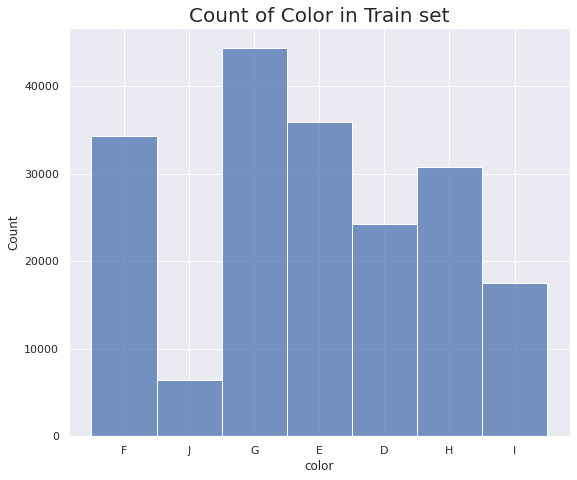

In [19]:
# Examining the 'color' of the cubic zirconia
plt.figure(figsize=(8, 7))
ax = sns.histplot(data=train_df, x='color')
ax.set_title('Count of Color in Train set', fontsize=20)
plt.show()

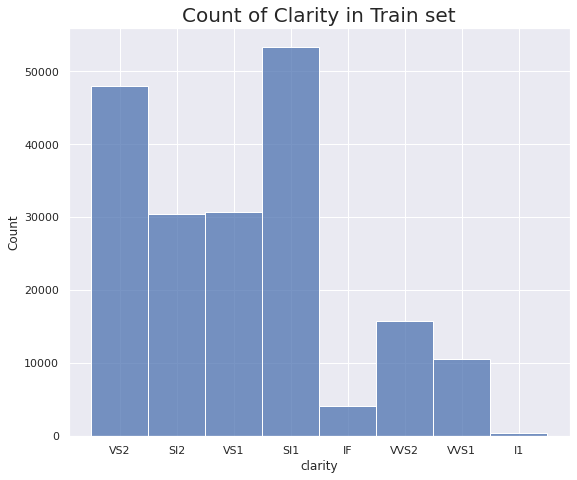

In [20]:
# Examining the 'clarity' of the cubic zirconia
plt.figure(figsize=(8, 7))
ax = sns.histplot(data=train_df, x='clarity')
ax.set_title('Count of Clarity in Train set', fontsize=20)
plt.show()

### Target Distribution

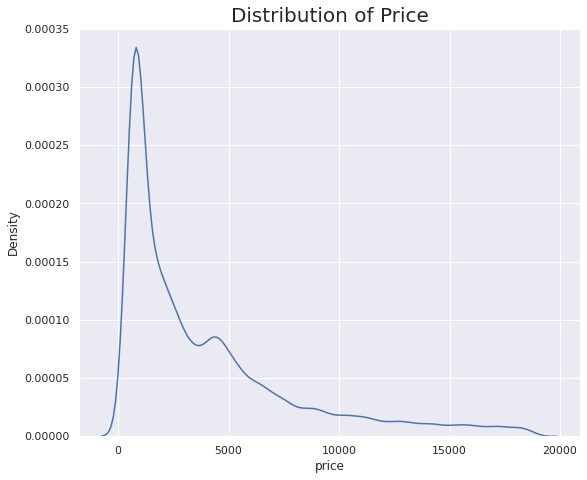

In [22]:
plt.figure(figsize=(8, 7))
ax = sns.kdeplot(data=train_df, x='price')
ax.set_title('Distribution of Price', fontsize=20)
plt.show()

## Converting Categorical Features into Ordinals

In [32]:
cuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
colors = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clars = ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']

cut_dict = {cuts[i] : i + 1 for i in range(len(cuts))}
color_dict = {colors[i] : i + 1 for i in range(len(colors))}
clar_dict = {clars[i] : i + 1 for i in range(len(clars))}

def convert_feat(dataframe):
  """
  A function that converts the categorical features to ordinals
  Returns: A copy of the original dataset with encoded values
  """
  df = dataframe.copy()
  df['cut'] = df['cut'].map(cut_dict)
  df['color'] = df['color'].map(color_dict)
  df['clarity'] = df['clarity'].map(clar_dict)
  return df

In [35]:
train_df_encoded = convert_feat(train_df)
test_df_encoded = convert_feat(test_df)

In [34]:
train_df_encoded.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,4,5,6,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,3,1,4,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,5,4,7,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,5,4,7,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,4,4,6,62.6,59.0,7.65,7.61,4.77,14453


## Trying Some Feature Engineering

In [36]:
def preprocess(dataset):
  """
  Adds some important features to the dataframe.
  Returns: A copy of the original dataset with the added features
  """
  df = dataset.copy()
  df['volume'] = df['x'] * df['y'] * df['z']
  df['density'] = df['volume'] / df['carat']
  return df

In [37]:
train_df_preprocessed = preprocess(train_df_encoded)
test_df_preprocessed = preprocess(test_df_encoded)

In [38]:
train_df_preprocessed.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price,volume,density
0,0,1.52,4,5,6,62.2,58.0,7.27,7.33,4.55,13619,242.465405,159.516714
1,1,2.03,3,1,4,62.0,58.0,8.06,8.12,5.05,13387,330.508360,162.812000
2,2,0.70,5,4,7,61.2,57.0,5.69,5.73,3.50,2772,114.112950,163.018500
3,3,0.32,5,4,7,61.6,56.0,4.38,4.41,2.71,666,52.345818,163.580681
4,4,1.70,4,4,6,62.6,59.0,7.65,7.61,4.77,14453,277.692705,163.348650


## Modelling

In [40]:
# Splitting the train and validation partitions
X = train_df_preprocessed.drop('price', axis=1)
y = train_df_preprocessed['price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model_pipelines = {
    'cat': Pipeline(steps=[
        ('cat_clf', CatBoostRegressor())
    ]),
    'xgb': Pipeline(steps=[
        ('xgb_clf', XGBRegressor())
    ]),
    'lgbm': Pipeline(steps=[
        ('lgbm_clf', LGBMRegressor())
    ])
}

In [55]:
params = {
    'cat': {
        'cat_clf__learning_rate': [0.001, 0.01],
        'cat_clf__depth': list(range(4, 11))
    },
    'xgb': {
        'xgb_clf__learning_rate': [0.1, 0.01, 0.001],
        'xgb_clf__n_estimators': [100, 150, 200],
        'xgb_clf__gamma': [0, 1, 5]
    },
    'lgbm': {
        'lgbm_clf__learning_rate': [0.01, 0.001]
    }
}

In [56]:
fit_models = dict()

In [57]:
for algo, pipe in model_pipelines.items():
  clf = RandomizedSearchCV(estimator=pipe, param_distributions=params[algo], random_state=42, cv=5)
  print(f'Training model: {algo}...')
  clf.fit(X_train, y_train)
  yhat_test = clf.predict(X_test)
  yhat_train = clf.predict(X_train)
  train_score = np.sqrt(mean_squared_error(y_train, yhat_train))
  test_score = np.sqrt(mean_squared_error(y_test, yhat_test))
  print(f'RMSE on training set: {train_score}.')
  print(f'RMSE on test set: {test_score}.')
  print(f'Best model params: {clf.best_params_}')
  print(f'Best model scores: {clf.best_score_}')
  fit_models[algo] = clf

Streaming output truncated to the last 5000 lines.
10:	learn: 3998.6518474	total: 233ms	remaining: 21s
11:	learn: 3994.9983582	total: 257ms	remaining: 21.1s
12:	learn: 3991.4048445	total: 277ms	remaining: 21.1s
13:	learn: 3987.7512766	total: 301ms	remaining: 21.2s
14:	learn: 3984.0997711	total: 331ms	remaining: 21.8s
15:	learn: 3980.4784993	total: 353ms	remaining: 21.7s
16:	learn: 3976.8367214	total: 379ms	remaining: 21.9s
17:	learn: 3973.1930406	total: 399ms	remaining: 21.8s
18:	learn: 3969.5529369	total: 419ms	remaining: 21.6s
19:	learn: 3965.9477961	total: 451ms	remaining: 22.1s
20:	learn: 3962.3831167	total: 472ms	remaining: 22s
21:	learn: 3958.7390546	total: 493ms	remaining: 21.9s
22:	learn: 3955.1795742	total: 513ms	remaining: 21.8s
23:	learn: 3951.5306573	total: 535ms	remaining: 21.8s
24:	learn: 3947.9346440	total: 557ms	remaining: 21.7s
25:	learn: 3944.3608059	total: 578ms	remaining: 21.6s
26:	learn: 3940.7425051	total: 601ms	remaining: 21.7s
27:	learn: 3937.2127048	total: 621m

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RMSE on training set: 1626.5116289762725.
RMSE on test set: 1626.5321102123023.
Best model params: {'lgbm_clf__learning_rate': 0.01}
Best model scores: 0.8375202249374116


## Predictions

In [58]:
test_df_preprocessed.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,volume,density
0,193573,0.35,5,7,6,62.3,56.0,4.51,4.54,2.82,57.740628,164.973223
1,193574,0.77,3,5,4,62.8,56.0,5.83,5.87,3.68,125.937328,163.554971
2,193575,0.71,5,2,6,61.9,53.0,5.77,5.74,3.55,117.575290,165.599000
3,193576,0.33,5,4,8,61.6,55.0,4.44,4.42,2.73,53.575704,162.350618
4,193577,1.20,3,2,6,62.7,56.0,6.75,6.79,4.24,194.329800,161.941500


In [59]:
test = test_df_preprocessed.copy()

In [61]:
preds = fit_models['xgb'].predict(test)

In [62]:
preds

array([ 864.4521, 2474.8591, 2347.4734, ..., 7612.372 , 5609.918 ,
       4276.8677], dtype=float32)

In [67]:
solution = pd.DataFrame([test['id'].astype('str'), preds]).T
solution.columns = ['id', 'price']
solution.head()

,id,price
0,193573,864.452087
1,193574,2474.859131
2,193575,2347.473389
3,193576,831.390747
4,193577,5779.230957


In [68]:
solution.to_csv('submission_1.csv', index=False)

In [69]:
preds_cat = fit_models['cat'].predict(test)

In [70]:
solution_cat = pd.DataFrame([test['id'].astype('str'), preds_cat]).T
solution_cat.columns = ['id', 'price']
solution_cat.head()

,id,price
0,193573,899.090598
1,193574,2532.185857
2,193575,2386.877624
3,193576,848.049109
4,193577,5845.304721


In [71]:
solution_cat.to_csv('submission_2.csv', index=False)